In [1]:
!pip install scipy==1.10.1 scikit-image==0.19.3 vit_keras==0.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 31.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 62.2 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata
  Attempting uninstall: scipy
    Found existing installation: SciPy 1.11.4
    Uninstalling SciPy-1.11.4:
      Successfully uninstalled SciPy-1.11.4
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.21.0
    Uninstalling scikit-image-0.21.0:
      Successfully uninstalled scikit-image-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but

In [2]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from vit_keras import vit, utils

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


#train_dir = '/kaggle/input/dogs-cats-images/dataset/training_set'
test_dir = '/kaggle/input/dogs-cats-images/dataset/test_set'

classes = os.listdir(test_dir)

resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(image, 255.0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std

    return image

def resize_and_crop(image, resize_size=256, crop_size=224):
    # Resize with bilinear interpolation
    resized_image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    cropped_image = tf.image.central_crop(resized_image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(cropped_image, 255.0) #normalize

    return image

def preprocess_for_attack(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

In [6]:
#xai 지표별 테스트 결과
def check_accuracy(test_dir, model_name):
    tf_list = []
    model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    for data_dir in [test_dir]:
        folderPath = data_dir
        for i in tqdm(range(len(df))):
            j = "-".join(df['path'].iloc[i].split("/")[4:])
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            try:
                img = preprocess_image(img)
                img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
                y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
                y_pred_single_label = np.argmax(y_pred, axis=1)
                tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
                #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
            except:
                pass
    print(f"model name: {model_name}, visualization: {test_dir.split('/')[-1]}")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)

In [8]:
from collections import Counter
import pandas as pd
import sys
import io

df = pd.read_csv('/kaggle/input/dog-cat-pandas/cat_dog_df.csv', index_col=0)
df = df[df['divide']=='test']
classes = ['dogs', 'cats']

for model_name in ['vgg']:
    for vis in ['deepfool_full', 'deepfool_negative', 'deepfool_super_pixel', 'deepfool_combine']:
        #sys.stdout = io.StringIO()
        test_dir = f'/kaggle/input/deepfool-vgg-sample/{model_name}/test/' + vis
        check_accuracy(test_dir, model_name)

100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


model name: vgg, visualization: deepfool_full
True : 929
False : 71


100%|██████████| 1000/1000 [01:14<00:00, 13.42it/s]


model name: vgg, visualization: deepfool_negative
True : 970
False : 30


100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


model name: vgg, visualization: deepfool_super_pixel
True : 948
False : 52


100%|██████████| 1000/1000 [01:20<00:00, 12.41it/s]

model name: vgg, visualization: deepfool_combine
True : 957
False : 43


In [19]:
import pandas as pd
import os
import cv2
import keras
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.applications import VGG16, EfficientNetV2L, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

#fine_tuning
model_name = 'vgg'
df = pd.read_csv('/kaggle/input/dog-cat-pandas/cat_dog_df.csv', index_col=0)
train_df, val_df = train_test_split(df[df['divide']=='validation'], test_size=0.2, random_state=42)
test_df = df[df['divide']=='test']
classes = ['dogs', 'cats']

def learning_rate_schedule(epoch, start_epoch=10, end_epoch=30, start_lr=0.005, end_lr=0.0002):
    if epoch <=5:
        return (0.001 * epoch)
    else:
        decay_rate = math.pow((end_lr/start_lr), (1/(end_epoch-start_epoch)))
        return (start_lr * math.pow(decay_rate, epoch - start_epoch))

def prepare_data(df, split):
    X, y = [], []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/{split}/deepfool_full"
    for i in range(len(df)):
        path = df.iloc[i]['path']
        j = "-".join(path.split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))
        img = preprocess_image(img)
        X.append(img)
        y.append(path.split("/")[-2])
    X = np.array(X)
    y = np.array(y)
    y = tf.keras.utils.to_categorical([classes.index(label) for label in y])
    return X, y

train_X, train_y = prepare_data(train_df, 'validation')
val_X, val_y = prepare_data(val_df, 'validation')
test_X, test_y = prepare_data(test_df, 'test')

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
num_layers_to_unfreeze = int(0.3 * len(base_model_vgg.layers))
for layer in base_model_vgg.layers[:-num_layers_to_unfreeze]:
    layer.trainable = False
for layer in base_model_vgg.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True
x = Flatten()(base_model_vgg.output)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model_vgg.input, outputs=output)
model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(learning_rate_schedule)
checkpoint_filepath = 'weights_{epoch:02d}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq='epoch',
    save_format='h5',
    verbose=1
)

model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=10, callbacks=[lr_scheduler, model_checkpoint_callback])

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9262
Epoch 1: saving model to weights_01.h5
25/25 [==============================] - 11s 240ms/step - loss: 0.2632 - accuracy: 0.9262 - val_loss: 0.2604 - val_accuracy: 0.9400 - lr: 0.0000e+00
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.9187
Epoch 2: saving model to weights_02.h5
25/25 [==============================] - 4s 168ms/step - loss: 0.2575 - accuracy: 0.9187 - val_loss: 0.2495 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9187
Epoch 3: saving model to weights_03.h5
25/25 [==============================] - 4s 165ms/step - loss: 0.2457 - accuracy: 0.9187 - val_loss: 0.2509 - val_accuracy: 0.9150 - lr: 0.0020
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9425
Epoch 4: saving model to weights_04.h5
25/25 [==============================] - 4s 167ms/step - loss: 0.2231 - accuracy: 0.9425 - val_loss: 0.2193 - val_accuracy: 0.9550 - lr: 0.0030
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9025
Epoch 5: saving model to weights_05.h5
25/25 [==============================] - 4s 169

In [20]:
##model testing
adversarial_true = []
adversarial_false = []
original_true = []
original_false = []
for epochs in range(1,11):
    model = keras.models.load_model(f'weights_{epochs:02d}.h5', compile=False)
    model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/deepfool_full"

    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
    print(str(epochs), ": adversarial samples")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            adversarial_true.append(count)
        else:
            adversarial_false.append(count)
        
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/original"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        #print(os.path.join(folderPath, j))
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensionsz
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(j.replace("-", ".").split(".")[-4], classes[int(y_pred_single_label)])
    print(str(epochs), ": clean dataset")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            original_true.append(count)
        else:
            original_false.append(count)

100%|██████████| 1000/1000 [01:11<00:00, 14.01it/s]


1 : adversarial samples
True : 929
False : 71


100%|██████████| 1000/1000 [01:16<00:00, 13.00it/s]


1 : clean dataset
True : 964
False : 36


100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


2 : adversarial samples
True : 937
False : 63


100%|██████████| 1000/1000 [01:10<00:00, 14.22it/s]


2 : clean dataset
True : 969
False : 31


100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


3 : adversarial samples
True : 935
False : 65


100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s]


3 : clean dataset
True : 970
False : 30


100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


4 : adversarial samples
True : 944
False : 56


100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


4 : clean dataset
True : 962
False : 38


100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


5 : adversarial samples
True : 942
False : 58


100%|██████████| 1000/1000 [01:10<00:00, 14.11it/s]


5 : clean dataset
True : 966
False : 34


100%|██████████| 1000/1000 [01:11<00:00, 13.93it/s]


6 : adversarial samples
True : 913
False : 87


100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


6 : clean dataset
True : 942
False : 58


100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]


7 : adversarial samples
True : 940
False : 60


100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s]


7 : clean dataset
True : 953
False : 47


100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


8 : adversarial samples
True : 953
False : 47


100%|██████████| 1000/1000 [01:11<00:00, 13.98it/s]


8 : clean dataset
True : 968
False : 32


100%|██████████| 1000/1000 [01:11<00:00, 14.02it/s]


9 : adversarial samples
True : 953
False : 47


100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


9 : clean dataset
True : 967
False : 33


100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


10 : adversarial samples
True : 954
False : 46


100%|██████████| 1000/1000 [01:09<00:00, 14.34it/s]

10 : clean dataset
True : 969
False : 31


In [21]:
##model testing
adversarial_true_v = []
adversarial_false_v = []
original_true_v = []
original_false_v = []
for epochs in range(1,11):
    model = keras.models.load_model(f'weights_{epochs:02d}.h5', compile=False)
    model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/validation/deepfool_full"

    for i in tqdm(range(len(val_df))):
        j = "-".join(val_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
    print(str(epochs), ": adversarial samples")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            adversarial_true_v.append(count)
        else:
            adversarial_false_v.append(count)
        
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/validation/original"
    for i in tqdm(range(len(val_df))):
        j = "-".join(val_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        #print(os.path.join(folderPath, j))
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensionsz
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(j.replace("-", ".").split(".")[-4], classes[int(y_pred_single_label)])
    print(str(epochs), ": clean dataset")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            original_true_v.append(count)
        else:
            original_false_v.append(count)

100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


1 : adversarial samples
True : 188
False : 12


100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


1 : clean dataset
True : 194
False : 6


100%|██████████| 200/200 [00:14<00:00, 14.00it/s]


2 : adversarial samples
True : 189
False : 11


100%|██████████| 200/200 [00:14<00:00, 14.26it/s]


2 : clean dataset
True : 194
False : 6


100%|██████████| 200/200 [00:14<00:00, 14.11it/s]


3 : adversarial samples
True : 183
False : 17


100%|██████████| 200/200 [00:14<00:00, 14.24it/s]


3 : clean dataset
True : 193
False : 7


100%|██████████| 200/200 [00:14<00:00, 14.09it/s]


4 : adversarial samples
True : 191
False : 9


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


4 : clean dataset
True : 192
False : 8


100%|██████████| 200/200 [00:14<00:00, 13.82it/s]


5 : adversarial samples
True : 187
False : 13


100%|██████████| 200/200 [00:14<00:00, 14.28it/s]


5 : clean dataset
True : 195
False : 5


100%|██████████| 200/200 [00:14<00:00, 14.11it/s]


6 : adversarial samples
True : 185
False : 15


100%|██████████| 200/200 [00:14<00:00, 14.24it/s]


6 : clean dataset
True : 190
False : 10


100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


7 : adversarial samples
True : 190
False : 10


100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


7 : clean dataset
True : 191
False : 9


100%|██████████| 200/200 [00:15<00:00, 12.92it/s]


8 : adversarial samples
True : 190
False : 10


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


8 : clean dataset
True : 192
False : 8


100%|██████████| 200/200 [00:14<00:00, 13.97it/s]


9 : adversarial samples
True : 189
False : 11


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


9 : clean dataset
True : 193
False : 7


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


10 : adversarial samples
True : 190
False : 10


100%|██████████| 200/200 [00:13<00:00, 14.31it/s]

10 : clean dataset
True : 192
False : 8


In [23]:
    adversarial_flat = []
    original_flat = []
    tf_list = []
    model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/deepfool_full"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
    print(str(epochs), ": adversarial samples")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            adversarial_flat.append(count)
    
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/original"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        img = cv2.imread(os.path.join(folderPath, j))  # Read image
        #print(os.path.join(folderPath, j))
        img = preprocess_image(img)
        img_batch = np.expand_dims(img, axis=0)  # Expand dimensionsz
        y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
        y_pred_single_label = np.argmax(y_pred, axis=1)
        tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(j.replace("-", ".").split(".")[-4], classes[int(y_pred_single_label)])
    print(str(epochs), ": clean dataset")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            original_flat.append(count)

100%|██████████| 1000/1000 [01:11<00:00, 14.02it/s]


10 : adversarial samples
True : 929
False : 71


100%|██████████| 1000/1000 [01:09<00:00, 14.36it/s]

10 : clean dataset
True : 964
False : 36


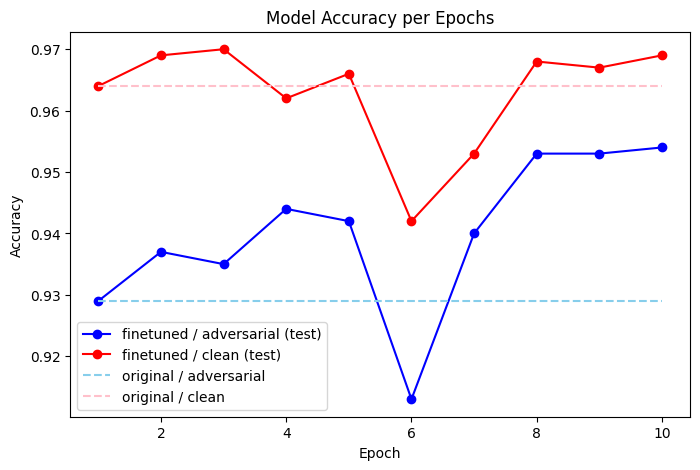

In [28]:
epochs = list(range(1, 11))  # 예시로 1부터 20까지의 에폭을 사용
#lr_values = [learning_rate_schedule(epoch) for epoch in epochs]

plt.figure(figsize = (8, 5))
plt.plot(epochs, [i/1000 for i in adversarial_true], marker='o', label = 'finetuned / adversarial (test)', color = 'blue')
plt.plot(epochs, [i/1000 for i in original_true], marker = 'o', label = 'finetuned / clean (test)', color = 'red')
plt.plot(epochs, [i/1000 for i in adversarial_flat] * 10, linestyle = 'dashed', color = 'skyblue', label = 'original / adversarial')
plt.plot(epochs, [i/1000 for i in original_flat] * 10, linestyle = 'dashed', color = 'pink', label = 'original / clean')
plt.legend()
plt.title('Model Accuracy per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

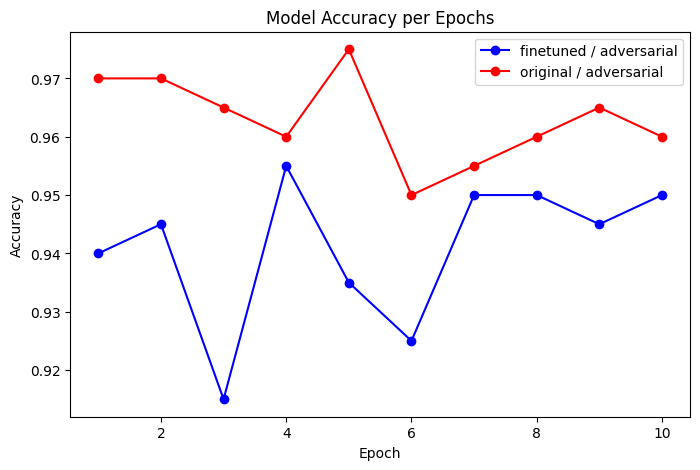

In [27]:
epochs = list(range(1, 11))  # 예시로 1부터 20까지의 에폭을 사용
#lr_values = [learning_rate_schedule(epoch) for epoch in epochs]

plt.figure(figsize = (8, 5))
plt.plot(epochs, [i/200 for i in adversarial_true_v], marker='o', label = 'finetuned / adversarial', color = 'blue')
plt.plot(epochs, [i/200 for i in original_true_v], marker='o', label = 'original / adversarial', color = 'red')
plt.legend()
plt.title('Model Accuracy per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [4]:
#xai 지표별 테스트 결과
def check_accuracy(test_dir, model_name):
    tf_list = []
    model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    for data_dir in [test_dir]:
        folderPath = data_dir
        for i in tqdm(range(500)):
            j = "-".join(df['path'].iloc[i].split("/")[4:])
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            try:
                img = preprocess_image(img)
                img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
                y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
                y_pred_single_label = np.argmax(y_pred, axis=1)
                tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
                #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
            except:
                pass
    print(f"model name: {model_name}, visualization: {test_dir.split('/')[-1]}")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)

In [5]:
from collections import Counter
import pandas as pd
import sys
import io

df = pd.read_csv('/kaggle/input/dog-cat-pandas/cat_dog_df.csv', index_col=0)
df = df[df['divide']=='test']
classes = ['dogs', 'cats']

for model_name in ['vit']:
    for vis in ['deepfool_full', 'deepfool_negative', 'deepfool_super_pixel', 'deepfool_combine']:
        #sys.stdout = io.StringIO()
        test_dir = f'/kaggle/input/deepfool-vgg-sample/{model_name}/vit/test/' + vis
        check_accuracy(test_dir, model_name)

100%|██████████| 500/500 [01:04<00:00,  7.71it/s]


model name: vit, visualization: deepfool_full
True : 485
False : 15


100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


model name: vit, visualization: deepfool_negative
True : 480
False : 20


100%|██████████| 500/500 [00:58<00:00,  8.57it/s]


model name: vit, visualization: deepfool_super_pixel
True : 481
False : 19


100%|██████████| 500/500 [00:59<00:00,  8.45it/s]

model name: vit, visualization: deepfool_combine
True : 481
False : 19


In [9]:
import pandas as pd
import os
import cv2
import keras
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.applications import VGG16, EfficientNetV2L, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

#fine_tuning
model_name = 'vit'
df = pd.read_csv('/kaggle/input/dog-cat-pandas/cat_dog_df.csv', index_col=0)
train_df, val_df = train_test_split(df[df['divide']=='validation'].head(500), test_size=0.2, random_state=42)
test_df = df[df['divide']=='test']
classes = ['dogs', 'cats']

def learning_rate_schedule(epoch, start_epoch=10, end_epoch=30, start_lr=0.005, end_lr=0.0002):
    if epoch <=5:
        return (0.001 * epoch)
    else:
        decay_rate = math.pow((end_lr/start_lr), (1/(end_epoch-start_epoch)))
        return (start_lr * math.pow(decay_rate, epoch - start_epoch))

def prepare_data(df, split):
    X, y = [], []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/{split}/deepfool_full"
    for i in range(len(df)):
        path = df.iloc[i]['path']
        j = "-".join(path.split("/")[4:])
        try:
            img = cv2.imread(os.path.join(folderPath, j))
            img = preprocess_image(img)
            X.append(img)
            y.append(path.split("/")[-2])
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    y = tf.keras.utils.to_categorical([classes.index(label) for label in y])
    return X, y

train_X, train_y = prepare_data(train_df, 'validation')
val_X, val_y = prepare_data(val_df, 'validation')
test_X, test_y = prepare_data(test_df, 'test')

base_model_vit = vit.vit_b16(
    image_size=224,
    classes=4,
    pretrained=True,
    pretrained_top=False)
num_layers_to_unfreeze = int(0.3 * len(base_model_vit.layers))
for layer in base_model_vit.layers[:-num_layers_to_unfreeze]:
    layer.trainable = False
for layer in base_model_vit.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True
x = Flatten()(base_model_vit.output)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model_vit.input, outputs=output)
model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(learning_rate_schedule)
checkpoint_filepath = 'weights_{epoch:02d}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq='epoch',
    save_format='h5',
    verbose=1
)

model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=10, callbacks=[lr_scheduler, model_checkpoint_callback])

[ WARN:0@600.459] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/validation/deepfool_full/dataset-training_set-cats-cat.1270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@600.460] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/validation/deepfool_full/dataset-training_set-dogs-dog.3852.jpg'): can't open/read file: check file path/integrity
[ WARN:0@600.460] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/validation/deepfool_full/dataset-training_set-dogs-dog.2060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@600.460] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/validation/deepfool_full/dataset-training_set-cats-cat.4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@600.460] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/validation/deepfoo

347502902/347502902 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9629
Epoch 1: saving model to weights_01.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 22s 751ms/step - loss: 0.1874 - accuracy: 0.9629 - val_loss: 0.1373 - val_accuracy: 1.0000 - lr: 0.0000e+00
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9455
Epoch 2: saving model to weights_02.h5
13/13 [==============================] - 8s 595ms/step - loss: 0.1901 - accuracy: 0.9455 - val_loss: 0.1364 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9678
Epoch 3: saving model to weights_03.h5
13/13 [==============================] - 8s 600ms/step - loss: 0.1813 - accuracy: 0.9678 - val_loss: 0.1349 - val_accuracy: 1.0000 - lr: 0.0020
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9530
Epoch 4: saving model to weights_04.h5
13/13 [==============================] - 8s 603ms/step - loss: 0.1815 - accuracy: 0.9530 - val_loss: 0.1333 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 5/10
13/13 [==

In [11]:
##model testing
adversarial_true = []
adversarial_false = []
original_true = []
original_false = []
for epochs in range(1,11):
    model = keras.models.load_model(f'weights_{epochs:02d}.h5', compile=False)
    model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/deepfool_full"

    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        try:
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            img = preprocess_image(img)
            img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
            y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
            y_pred_single_label = np.argmax(y_pred, axis=1)
            tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        except:
            pass
        #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
    print(str(epochs), ": adversarial samples")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            adversarial_true.append(count)
        else:
            adversarial_false.append(count)
        
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/original"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        try:
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            #print(os.path.join(folderPath, j))
            img = preprocess_image(img)
            img_batch = np.expand_dims(img, axis=0)  # Expand dimensionsz
            y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
            y_pred_single_label = np.argmax(y_pred, axis=1)
            tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        #print(j.replace("-", ".").split(".")[-4], classes[int(y_pred_single_label)])
        except:
            pass
    print(str(epochs), ": clean dataset")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            original_true.append(count)
        else:
            original_false.append(count)

 50%|█████     | 500/1000 [00:56<00:51,  9.65it/s][ WARN:0@798.968] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@798.969] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@798.969] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@798.969] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@798.970] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sampl

1 : adversarial samples
True : 485
False : 15


 50%|█████     | 500/1000 [00:53<00:56,  8.89it/s][ WARN:0@852.938] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@852.939] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@852.939] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@852.940] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@852.941] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/origi

1 : clean dataset
True : 481
False : 19


 50%|█████     | 500/1000 [00:55<00:53,  9.32it/s][ WARN:0@913.147] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@913.147] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@913.148] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@913.148] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@913.148] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sampl

2 : adversarial samples
True : 485
False : 15


 50%|█████     | 500/1000 [00:52<00:51,  9.74it/s][ WARN:0@965.358] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@965.359] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@965.359] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@965.359] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@965.360] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/origi

2 : clean dataset
True : 481
False : 19


 50%|█████     | 500/1000 [00:55<00:52,  9.55it/s][ WARN:0@1025.081] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1025.081] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1025.081] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1025.082] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1025.082] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

3 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:51<00:52,  9.59it/s][ WARN:0@1077.166] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1077.166] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1077.166] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1077.167] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1077.167] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

3 : clean dataset
True : 480
False : 20


 50%|█████     | 500/1000 [00:57<00:52,  9.57it/s][ WARN:0@1137.974] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1137.975] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1137.975] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1137.976] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1137.976] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

4 : adversarial samples
True : 487
False : 13


 50%|█████     | 500/1000 [00:52<00:51,  9.80it/s][ WARN:0@1190.523] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1190.524] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1190.524] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1190.525] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1190.525] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

4 : clean dataset
True : 481
False : 19


 50%|█████     | 500/1000 [00:55<00:54,  9.22it/s][ WARN:0@1250.281] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1250.281] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1250.282] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1250.282] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1250.283] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

5 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:54,  9.20it/s][ WARN:0@1302.617] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1302.617] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1302.617] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1302.617] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1302.618] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

5 : clean dataset
True : 480
False : 20


 50%|█████     | 500/1000 [00:56<00:53,  9.34it/s][ WARN:0@1363.784] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1363.785] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1363.785] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1363.785] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1363.786] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

6 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:52,  9.55it/s][ WARN:0@1416.235] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1416.235] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1416.235] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1416.236] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1416.236] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

6 : clean dataset
True : 479
False : 21


 50%|█████     | 500/1000 [00:56<00:51,  9.67it/s][ WARN:0@1477.267] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1477.268] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1477.268] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1477.268] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1477.268] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

7 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:51,  9.69it/s][ WARN:0@1529.433] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1529.434] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1529.434] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1529.434] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1529.434] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

7 : clean dataset
True : 479
False : 21


 50%|█████     | 500/1000 [00:59<00:52,  9.47it/s][ WARN:0@1592.004] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1592.004] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1592.005] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1592.005] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1592.005] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

8 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:51,  9.73it/s][ WARN:0@1644.537] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1644.538] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1644.538] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1644.539] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1644.539] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

8 : clean dataset
True : 479
False : 21


 50%|█████     | 500/1000 [00:55<00:53,  9.38it/s][ WARN:0@1704.442] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1704.442] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1704.443] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1704.443] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1704.443] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

9 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:55,  9.09it/s][ WARN:0@1756.766] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1756.767] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1756.767] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1756.767] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1756.768] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

9 : clean dataset
True : 478
False : 22


 50%|█████     | 500/1000 [00:57<00:53,  9.34it/s][ WARN:0@1818.312] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1818.313] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1818.313] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1818.313] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1818.314] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

10 : adversarial samples
True : 486
False : 14


 50%|█████     | 500/1000 [00:52<00:51,  9.67it/s][ WARN:0@1870.466] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1870.467] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1870.467] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1870.467] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1870.467] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

10 : clean dataset
True : 478
False : 22


In [16]:
    adversarial_flat = []
    original_flat = []
    tf_list = []
    model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/deepfool_full"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        try:
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            img = preprocess_image(img)
            img_batch = np.expand_dims(img, axis=0)  # Expand dimensions
            y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
            y_pred_single_label = np.argmax(y_pred, axis=1)
            tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        except:
            pass
        #print(classes[int(y_pred_single_label)], j.replace("-", ".").split(".")[-4])
    print(str(epochs), ": adversarial samples")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            adversarial_flat.append(count)
    
    tf_list = []
    folderPath = f"/kaggle/input/deepfool-vgg-sample/{model_name}/{model_name}/test/original"
    for i in tqdm(range(len(test_df))):
        j = "-".join(test_df['path'].iloc[i].split("/")[4:])
        try:
            img = cv2.imread(os.path.join(folderPath, j))  # Read image
            #print(os.path.join(folderPath, j))
            img = preprocess_image(img)
            img_batch = np.expand_dims(img, axis=0)  # Expand dimensionsz
            y_pred = model.predict(img_batch, verbose=0)  # Use img_batch here
            y_pred_single_label = np.argmax(y_pred, axis=1)
            tf_list.append(classes[int(y_pred_single_label)]==j.replace("-", ".").split(".")[-4])
        except:
            pass
        #print(j.replace("-", ".").split(".")[-4], classes[int(y_pred_single_label)])
    print(str(epochs), ": clean dataset")
    counts = Counter(tf_list)
    for element, count in counts.items():
        print(element, ":", count)
        if element == True:
            original_flat.append(count)

 50%|█████     | 500/1000 [00:57<00:53,  9.43it/s][ WARN:0@2090.325] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2090.326] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2090.326] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2090.326] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/deepfool_full/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2090.326] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] : adversarial samples
True : 485
False : 15


 50%|█████     | 500/1000 [00:54<00:52,  9.52it/s][ WARN:0@2145.030] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1909.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2145.031] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.310.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2145.032] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-cats-cat.2516.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2145.032] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.3854.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2145.032] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] : clean dataset
True : 481
False : 19


[ WARN:0@2145.134] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/deepfool-vgg-sample/vit/vit/test/original/dataset-training_set-dogs-dog.1336.jpg'): can't open/read file: check file path/integrity



In [15]:
adversarial_flat

[]

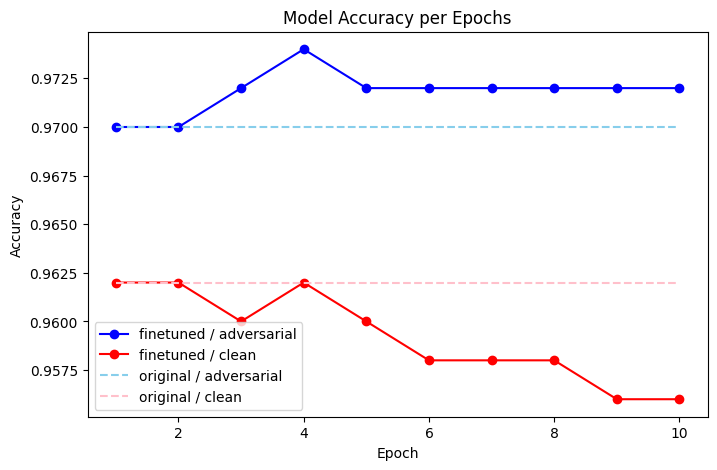

In [17]:
epochs = list(range(1, 11))  # 예시로 1부터 20까지의 에폭을 사용
#lr_values = [learning_rate_schedule(epoch) for epoch in epochs]

plt.figure(figsize = (8, 5))
plt.plot(epochs, [i/500 for i in adversarial_true], marker='o', label = 'finetuned / adversarial', color = 'blue')
plt.plot(epochs, [i/500 for i in original_true], marker = 'o', label = 'finetuned / clean', color = 'red')
plt.plot(epochs, [i/500 for i in adversarial_flat] * 10, linestyle = 'dashed', color = 'skyblue', label = 'original / adversarial')
plt.plot(epochs, [i/500 for i in original_flat] * 10, linestyle = 'dashed', color = 'pink', label = 'original / clean')
plt.legend()
plt.title('Model Accuracy per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

def ifgsm_attack(model, image, label, epsilon=0.001, num_iter=30, clip_min=0.0, clip_max=1.0):
    adv_image = tf.identity(image)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(preprocess_for_attack(adv_image))
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

        gradient = tape.gradient(loss, adv_image)
        perturbation = epsilon * tf.sign(gradient)

        adv_image = tf.clip_by_value(adv_image + perturbation, clip_min, clip_max)

    #adv_image_np = adv_image.numpy().squeeze()  # Squeeze to remove channel dimension
    del gradient, perturbation

    return adv_image


import sys
import io
import gc
import ctypes
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
from vit_keras import vit, utils
import lime
import skimage
import shap
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from lime.lime_image import LimeImageExplainer
import ctypes



def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image


def resize_and_crop(image, resize_size=256, crop_size=224):
    # Resize with bilinear interpolation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    cropped_image = tf.image.central_crop(resized_image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(cropped_image, 255.0) #normalize

    return image

def ifgsm_attack(model, image, label, epsilon=0.001, num_iter=30, clip_min=0.0, clip_max=1.0):
    adv_image = tf.identity(image)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(preprocess_for_attack(adv_image))
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

        gradient = tape.gradient(loss, adv_image)
        perturbation = epsilon * tf.sign(gradient)

        adv_image = tf.clip_by_value(adv_image + perturbation, clip_min, clip_max)

    #adv_image_np = adv_image.numpy().squeeze()  # Squeeze to remove channel dimension
    del gradient, perturbation

    return adv_image

import tensorflow as tf
import numpy as np

def ifgsm_attack_transparency(model, masked_image, original_image, label, epsilon=0.001, num_iterations=30):
    # Ensure the input is a float type
    masked_image = np.expand_dims(masked_image, axis=0)
    perturbed_image = tf.cast(masked_image, tf.float32)

    # Loop over the number of iterations
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            prediction = model(perturbed_image[..., :3])  # Exclude alpha channel for model prediction
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
            
        # Calculate gradients
        gradient = tape.gradient(loss, perturbed_image)[..., :3]  # Exclude alpha channel in gradient

        # Apply gradients only where the alpha channel is non-zero
        alpha_channel = perturbed_image[..., -1:]
        masked_gradient = gradient * tf.cast(alpha_channel > 0, tf.float32)

        # Apply the perturbation
        perturbed_image = perturbed_image[..., :3] + epsilon * tf.sign(masked_gradient)
        perturbed_image = tf.concat([perturbed_image, alpha_channel], axis=-1)  # Re-add the alpha channel

        # Ensure the perturbed image is still valid
        perturbed_image = tf.clip_by_value(perturbed_image, 0, 255)
        
    # Replace the areas not attacked with original image
    # Replace the areas not attacked with the original image
    mask = alpha_channel > 0
    mask_float = tf.cast(mask, tf.float32)  # Convert the boolean mask to float

    # Ensure original_image and perturbed_image are of the same type (e.g., float32)
    original_image_float = tf.cast(original_image, tf.float32)
    perturbed_image_float = tf.cast(perturbed_image[..., :3], tf.float32)

    # Combine the images using the mask
    result_image = original_image_float * (1 - mask_float) + perturbed_image_float * mask_float
    
    del perturbed_image, mask,original_image_float, perturbed_image_float

    return result_image


def preprocess_for_attack(image):

    # 이미지 정규화
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std

    return image


def plot_images(original, temp, mask, model_name, model_type, file_name, label, model):
    width_in_inches = height_in_inches = 224 / 100
    save_paths = [f'{model_name}/{model_type}/original/', f'{model_name}/{model_type}/superpixel/', f'{model_name}/{model_type}/pos_neg/'
                 , f'{model_name}/{model_type}/ifgsm_super_pixel/', f'{model_name}/{model_type}/ifgsm_full/',
                 f'{model_name}/{model_type}/ifgsm_negative/', f'{model_name}/{model_type}/ifgsm_pos+neg/',
                  f'{model_name}/{model_type}/neg/', f'{model_name}/{model_type}/combine/']
    
    for save_path in save_paths:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

    ##original image###
    plt.figure(figsize=(width_in_inches, height_in_inches))
    plt.imshow(original)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/original/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    
    ###super pixel + attack super pixel ###
    masked_positive = np.copy(original)
    masked_positive = np.concatenate((masked_positive, np.ones((*masked_positive.shape[:-1], 1), dtype=masked_positive.dtype) * 255), axis=-1)  # Add alpha channel
    masked_positive[mask <= 0, -1] = 0
    
    plt.imshow(masked_positive)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/superpixel/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    masked_positive_adv = ifgsm_attack_transparency(model, masked_positive, original, label)
    masked_positive_adv = np.squeeze(masked_positive_adv, axis=0)

    plt.imshow(masked_positive_adv)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/ifgsm_super_pixel/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close() 
    
    
    ##attack negative pixel###
    masked_negative = np.copy(original)
    masked_negative = np.concatenate((masked_negative, np.ones((*masked_negative.shape[:-1], 1), dtype=masked_negative.dtype) * 255), axis=-1)  # Add alpha channel
    masked_negative[mask >= 0, -1] = 0
    
    plt.imshow(masked_negative)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/neg/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()

    masked_negative_adv = ifgsm_attack_transparency(model, masked_negative, original, label)
    masked_negative_adv = np.squeeze(masked_negative_adv, axis=0)

    plt.imshow(masked_negative_adv)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/ifgsm_negative/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()

    
    #attack pos+negative pixel###
    masked_combined = np.copy(original)
    masked_combined = np.concatenate((masked_combined, np.ones((*masked_combined.shape[:-1], 1), dtype=masked_negative.dtype) * 255), axis=-1)  # Add alpha channel
    masked_combined[mask == 0, -1] = 0
    
    plt.imshow(masked_combined)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/combine/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()

    masked_combined_adv = ifgsm_attack_transparency(model, masked_combined, original, label)
    masked_combined_adv = np.squeeze(masked_combined_adv, axis=0)

    plt.imshow(masked_combined_adv)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/ifgsm_pos+neg/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()

    # Lime Mask를 원본 이미지에 적용하여 긍부정 시각화
    masked_negative = np.zeros_like(original)
    masked_negative[mask < 0] = [255, 0, 0]
    

    # Create a new image for positive parts (green color)
    masked_positive = np.zeros_like(original)
    masked_positive[mask > 0] = [0, 255, 0]

    # Combine the positive and negative images
    combined_image = original + masked_negative + masked_positive

    # Display the result with larger size
    plt.imshow(combined_image)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/pos_neg/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    original_image = np.expand_dims(original, axis=0)
    original_attack = ifgsm_attack(model, original_image, label)
    original_attack = np.squeeze(original_attack, axis=0)
    plt.imshow(original_attack)
    plt.axis('off')
    plt.savefig(os.path.join(f'{model_name}/{model_type}/ifgsm_full/', f'{file_name}'), bbox_inches='tight', pad_inches=0)
    plt.close()
    
    del masked_positive, masked_positive_adv, masked_negative, masked_negative_adv, masked_combined, masked_combined_adv
    del combined_image, original_image, original_attack
    
    plt.cla()
    plt.clf()
    
def iFGSM_and_LIME(df, i, model):
    img = cv2.imread(df['path'].iloc[i])
    selected_image = preprocess_image(img)
    y = 0 if df['label'].iloc[i]=='dogs' else 1
    Original_image = resize_and_crop(img)
    selected_image = np.expand_dims(selected_image, axis=0)
    prediction = model.predict(selected_image)
    predicted_class = np.argmax(prediction)
    explainer = lime.lime_image.LimeImageExplainer(feature_selection='auto')
    explanation = explainer.explain_instance(selected_image[0], model.predict, top_labels=1, hide_color=0, num_samples=100)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plot_images(Original_image, temp, mask, model_name, df['divide'].iloc[i], "/".join(df['path'].iloc[i].split('/')[4:]).replace("/","-"), y, model)
    del Original_image, selected_image, explainer, explanation, temp, mask, img
    return ['dogs', 'cats'][predicted_class], df['label'].iloc[i]
    
def file_split(range_, df, model):
    for i in tqdm(range_):
        full_prediction, full_true = iFGSM_and_LIME(df, i, model)
        print(full_prediction, full_true)

if __name__ == '__main__':
    ctypes.CDLL("libc.so.6").malloc_trim(0) 
    count = 0
    start = 800
    resize_size = 256
    crop_size = 224

    while True:
        end = 1000
        df = pd.read_csv('/kaggle/input/dog-cat-pandas/cat_dog_df.csv', index_col=0)
        df = df[df['divide']=='test']
        model_name = 'vit'
        model = keras.models.load_model('/kaggle/input/dog-and-cat-classifier/'+model_name+"_best_model.h5", compile=False)
        model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
        file_split(range(start, end), df, model)
        gc.collect()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        start += 500
        break